# Quantum state tomography

One can open it in Google Colab (is recommended)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LuchnikovI/QGOpt/blob/Dev/docs/source/state_tomography.ipynb)

In the given tutorial, we perform quantum state tomography via the manifold of density matrices. First of all, let us import some libraries.

In [1]:
import numpy as np
from math import sqrt
import tensorflow as tf  # tf 2.x

try:
    import QGOpt as qgo
except ImportError:
    !pip install git+https://github.com/LuchnikovI/QGOpt
    import QGOpt as qgo

# TensorNetwork library
try:
    import tensornetwork as tn
except ImportError:
    !pip install tensornetwork
    import tensornetwork as tn

import matplotlib.pyplot as plt
from tqdm import tqdm
tn.set_default_backend("tensorflow")

# Fix random seed to make results reproducable.
tf.random.set_seed(42)

## Many-qubits, informationally complete, positive operator-valued measure (IC POVM)

Before generating measurement outcomes and performing quantum state tomography, one needs to introduce POVM describing quantum measurements. For simplicity, we use one-qubit tetrahedral POVM and generalize it on a many-qubit case by taking tensor products between POVM elements, i.e. $\{M_\alpha\}_{\alpha=1}^4$ is the one-qubit tetrahedral POVM, $\{M_{\alpha_1}\otimes \dots \otimes M_{\alpha_N}\}_{\alpha_1=1,\dots,\alpha_N=1}^4$ is the many-qubits tetrahedral POVM.

In [2]:
# auxiliary function that returns Kronecker product between POVM elements
def kron(A, B):
    """Kronecker product of two POVM elements.

    Args:
        A: complex valued tensor of shape (q, n, k).
        B: complex valued tensor of shape (p, m, l).

    Returns:
        complex valued tensor of shape (q * p, n * m, k * l)"""

    AB = tf.tensordot(A, B, axes=0)
    AB = tf.transpose(AB, (0, 3, 1, 4, 2, 5))
    shape = AB.shape
    AB = tf.reshape(AB, (shape[0] * shape[1],
                         shape[2] * shape[3],
                         shape[4] * shape[5]))
    return AB

# number of qubits in many-qubits POVMs
num_of_qubits = [1, 2, 3]  # number of qubits

# Pauli matrices
sigma_x = tf.constant([[0, 1], [1, 0]], dtype=tf.complex128)
sigma_y = tf.constant([[0 + 0j, -1j], [1j, 0 + 0j]], dtype=tf.complex128)
sigma_z = tf.constant([[1, 0], [0, -1]], dtype=tf.complex128)

# All Pauli matrices in one tensor of shape (3, 2, 2)
sigma = tf.concat([sigma_x[tf.newaxis],
                   sigma_y[tf.newaxis],
                   sigma_z[tf.newaxis]], axis=0)

# coordinates of thetrahedron peaks (is needed to build tetr. POVM)
s0 = tf.constant([0, 0, 1], dtype=tf.complex128)
s1 = tf.constant([2 * sqrt(2) / 3, 0, -1/3], dtype=tf.complex128)
s2 = tf.constant([-sqrt(2) / 3, sqrt(2 / 3), -1 / 3], dtype=tf.complex128)
s3 = tf.constant([-sqrt(2) / 3, -sqrt(2 / 3), -1 / 3], dtype=tf.complex128)

# coordinates of thetrahedron peaks in one tensor
s = tf.concat([s0[tf.newaxis],
               s1[tf.newaxis],
               s2[tf.newaxis],
               s3[tf.newaxis]], axis=0)

# One qubit thetrahedral POVM
M = 0.25 * (tf.eye(2, dtype=tf.complex128) + tf.tensordot(s, sigma, axes=1))

# Many qubits POVMs
povms = []
for n in num_of_qubits:
    Mmq = M
    for _ in range(n - 1):
        Mmq = kron(Mmq, M)
    povms.append(Mmq)

## Data set generation (measurement outcomes simulation).

Here we generate a set of measurements (training set). First of all, we generate a random density matrix that is the target state we want to reconstruct. Then we simulate measurement outcomes over the target state driven by tetrahedral POVM.

In [3]:
num_of_meas = 600000  # number of measurements

data_sets = {}  # dict will be filled by number_of_qubits: data_set
true_states = {}  # will be filled by target density matrices
for i, n in enumerate(num_of_qubits):

    # random (target) density matrix
    m = qgo.manifolds.DensityMatrix()
    A = m.random((2 ** n, 2 ** n), dtype=tf.complex128)
    rho = A @ tf.linalg.adjoint(A)
    true_states[n] = rho  # adding state to the dict with target states

    # Measurements simulation (by using Gumbel trick for sampling from a
    # discrete distribution)
    P = tf.cast(tf.einsum('qjk,kj->q', povms[i], rho), dtype=tf.float64)
    eps = tf.random.uniform((num_of_meas, 2 ** (2 * n)), dtype=tf.float64)
    eps = -tf.math.log(-tf.math.log(eps))
    ind_set = tf.math.argmax(eps + tf.math.log(P), axis=-1)

    # projectors came true
    M_set = tf.gather_nd(povms[i], ind_set[:, tf.newaxis])

    data_sets[n] = M_set # data sets filling

## Optimization loop

Here we perform maximization of logarithmic likelihood. In order to preserve constraints of a density matrix, we use the manifold of density matrices. The manifold of density matrices is imlemented differently in comparison with other manifolds. Any density matrix $\rho$ is represented by a matrix $A$, where $\rho = AA^\dagger$. Since there is an equivalence relation between $A\sim AQ$, where $Q$ is an arbitrary unitary matrix, optimization is performed on the quotient manifold eliminating this simmetry. The corresponding quotient geometry is described in

Yatawatta, S. (2013, May). Radio interferometric calibration using a Riemannian manifold. In 2013 IEEE International Conference on Acoustics, Speech and Signal Processing (pp. 3866-3870). IEEE.

In [5]:
# Parameters of learning
#=========================================#
lr = 0.07  # learning rate
num_of_iter = 400  # number of iterations
#=========================================#

# manifold of density matrices
m = qgo.manifolds.DensityMatrix()

# dict will be filled by validation curve per data set
distances = {}

# loop over data sets
for n in num_of_qubits:

    # initial parametrization
    A = m.random((2 ** n, 2 ** n), dtype=tf.complex128)
    # real representation of the initial parametrization
    A = qgo.manifolds.complex_to_real(A)
    # variable to optimize
    A = tf.Variable(A)

    # optimizer initialization
    opt = qgo.optimizers.RAdam(m, lr) # riemannian optimizer

    # to be filled by trace distance between density matrices vs iteration
    dist = []

    # optimization loop
    for _ in tqdm(range(num_of_iter)):
        with tf.GradientTape() as tape:
            # complex representation of a parametrization
            A_c = qgo.manifolds.real_to_complex(A)
            # density matrix
            rho = A_c @ tf.linalg.adjoint(A_c)
            # probabilities of measurement outcomes
            p = tf.abs(tf.linalg.trace(data_sets[n] @ rho))
            # mean negative log likelihood (to be optimized)
            loss = -tf.reduce_mean(tf.math.log(p))
        grad = tape.gradient(loss, A)  # gradient
        opt.apply_gradients(zip([grad], [A]))  # optimization step
        # append current trace distance between the target denisty matrix and
        # the reconstructed density matrix to the list of distances
        dist.append(tf.reduce_sum(tf.abs(tf.linalg.eigvalsh(rho -\
                                    true_states[n]))))
    distances[n] = dist  # filling dict with validation curves

100%|██████████| 400/400 [04:00<00:00,  1.66it/s]


## Validation curves

Here we plot validation curves.

Text(0.5, 0, '$iter$')

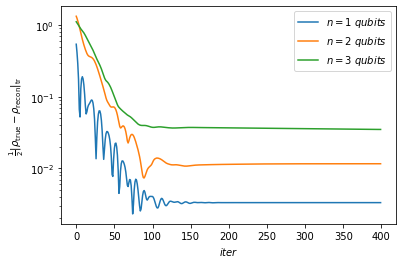

In [7]:
for n in num_of_qubits:
    plt.plot(distances[n])
plt.legend([r'$n=$' + str(n) + r'$\ qubits$' for n in num_of_qubits])
plt.yscale('log')
plt.ylabel(r'$\frac{1}{2}\|\rho_{\rm true} - \rho_{\rm recon}\|_{\rm tr}$')
plt.xlabel(r'$iter$')